In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from torch.utils.data import DataLoader, TensorDataset

In [29]:
apps_data = pd.read_csv('filtered_apps.csv')
users_data = pd.read_csv('filtered_users.csv')
jobs_data = pd.read_csv('filtered_jobs.csv')

In [30]:
apps = apps_data.copy()
users = users_data.copy()
jobs = jobs_data.copy()

In [31]:
unique_JobID = apps['JobID'].unique()
unique_UserID = apps['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
user_new2old_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    user_new2old_id_dict[j] = u
    j += 1
j = 0
job_old2new_id_dict = dict()
job_new2old_id_dict = dict()
for i in unique_JobID:
    job_old2new_id_dict[i] = j
    job_new2old_id_dict[j] = i
    j += 1

In [32]:
user_list = apps['UserID'].values
job_list = apps['JobID'].values
for j in range(len(apps)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    job_list[j] = job_old2new_id_dict[job_list[j]]
apps['UserID'] = user_list
apps['JobID'] = job_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(apps)) <= 0.7
train_df = apps[train_index]
test_df = apps[~train_index]

In [33]:
train_df['Applied?'] = 1
test_df['Applied?'] = 1

from scipy.sparse import coo_matrix

# generate train_mat and test_mat
num_users = len(apps['UserID'].unique())
num_jobs = len(apps['JobID'].unique())

train_mat = coo_matrix((train_df['Applied?'].values, (train_df['UserID'].values, train_df['JobID'].values)), shape=(num_users, num_jobs)).astype(float).toarray()
test_mat = coo_matrix((test_df['Applied?'].values, (test_df['UserID'].values, test_df['JobID'].values)), shape=(num_users, num_jobs)).astype(float).toarray()

<ipython-input-33-f1ba62f7282d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Applied?'] = 1
<ipython-input-33-f1ba62f7282d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Applied?'] = 1


## MF Model

In [34]:
def MF_PreTrained_Embeddings(latent_factors, num_epochs):
  P = np.random.rand(num_users, latent_factors)
  Q = np.random.rand(latent_factors, num_jobs)

  a = 0.01
  b = 0.01
  train_loss = []
  test_loss = []
  nonzero_indices_train = np.nonzero(train_mat)
  nonzero_indices_test = np.nonzero(test_mat)

  for epoch in range(num_epochs):
      for i in range(num_users):
          for j in range(num_jobs):
              if train_mat[i, j] > 0:
                  diff = train_mat[i, j] - np.dot(P[i, :], Q[:, j])
                  P[i, :] += a * (diff * Q[:, j] - b * P[i, :])
                  Q[:, j] += a * (diff * P[i, :] - b * Q[:, j])

      predicted_matrix = np.dot(P, Q)

      rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
      rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

      train_loss.append(rmse_train)
      test_loss.append(rmse_test)

      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(rmse_test))

  return P, Q

In [35]:
latent_factors_for_MF = 5
num_epochs = 20
P1, Q1 = MF_PreTrained_Embeddings(latent_factors_for_MF, num_epochs)

Epoch 1 of 20: RMSE Train Loss: 0.4065, RMSE Test Loss: 0.4238
Epoch 2 of 20: RMSE Train Loss: 0.3336, RMSE Test Loss: 0.3606
Epoch 3 of 20: RMSE Train Loss: 0.2874, RMSE Test Loss: 0.3206
Epoch 4 of 20: RMSE Train Loss: 0.2549, RMSE Test Loss: 0.2923
Epoch 5 of 20: RMSE Train Loss: 0.2305, RMSE Test Loss: 0.2709
Epoch 6 of 20: RMSE Train Loss: 0.2114, RMSE Test Loss: 0.2540
Epoch 7 of 20: RMSE Train Loss: 0.1958, RMSE Test Loss: 0.2401
Epoch 8 of 20: RMSE Train Loss: 0.1829, RMSE Test Loss: 0.2286
Epoch 9 of 20: RMSE Train Loss: 0.1720, RMSE Test Loss: 0.2187
Epoch 10 of 20: RMSE Train Loss: 0.1625, RMSE Test Loss: 0.2101
Epoch 11 of 20: RMSE Train Loss: 0.1544, RMSE Test Loss: 0.2026
Epoch 12 of 20: RMSE Train Loss: 0.1471, RMSE Test Loss: 0.1960
Epoch 13 of 20: RMSE Train Loss: 0.1407, RMSE Test Loss: 0.1901
Epoch 14 of 20: RMSE Train Loss: 0.1350, RMSE Test Loss: 0.1848
Epoch 15 of 20: RMSE Train Loss: 0.1298, RMSE Test Loss: 0.1799
Epoch 16 of 20: RMSE Train Loss: 0.1251, RMSE Tes

In [36]:
train_df.head()

,UserID,WindowID,Split,ApplicationDate,JobID,Applied?
0,0,1,Train,2012-04-02 11:05:25.333,0,1
1,0,1,Train,2012-04-02 05:08:41.413,1,1
3,0,1,Train,2012-04-02 11:05:25.833,3,1
4,0,1,Train,2012-04-02 11:05:25.76,4,1
5,0,1,Train,2012-04-02 05:08:44.72,5,1


In [37]:
test_df.head()

,UserID,WindowID,Split,ApplicationDate,JobID,Applied?
2,0,1,Train,2012-04-02 11:05:24.333,2,1
8,0,1,Train,2012-04-02 05:08:40.687,8,1
10,0,1,Train,2012-04-02 11:05:23.78,10,1
12,0,1,Train,2012-04-02 11:05:25.01,12,1
15,0,1,Train,2012-04-02 11:05:25.1,15,1


In [38]:
from torch.utils.data import DataLoader, TensorDataset
import torch
train_user_ids = torch.LongTensor(train_df['UserID'].values)
train_job_ids = torch.LongTensor(train_df['JobID'].values)
train_job_features = torch.FloatTensor(train_df['Applied?'].values.astype(np.float32))

train_dataset = TensorDataset(train_user_ids, train_job_ids, train_job_features)
batch_size = 256

# Create a DataLoader that generates batches of data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_user_ids = torch.LongTensor(test_df['UserID'].values)
test_job_ids = torch.LongTensor(test_df['JobID'].values)
test_job_features = torch.FloatTensor(test_df['Applied?'].values.astype(np.float32))

test_dataset = TensorDataset(test_user_ids, test_job_ids, test_job_features)

# Create a DataLoader that generates batches of data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [39]:
train_dataloader

## NCF Model

In [48]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np

# Define your NCF model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim, pretrained_user_embs, pretrained_item_embs):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        if pretrained_user_embs is not None:
            self.user_embedding.weight.data.copy_(torch.from_numpy(pretrained_user_embs))
        if pretrained_item_embs is not None:
            self.item_embedding.weight.data.copy_(torch.from_numpy(pretrained_item_embs))

    def forward(self, user, item):
        user_embed = self.user_embedding(user)
        item_embed = self.item_embedding(item)
        concat_embed = torch.cat((user_embed, item_embed), -1)
        out = self.fc_layers(concat_embed)
        return out.squeeze(), user_embed, item_embed  # Return user and item embeddings



In [55]:
def train_NCF(model, train_loader, test_loader, lr, num_epochs):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    test_loss = []
    user_latent = None
    item_latent = None

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = []

        for user, item, ifApplied in train_loader:
            optimizer.zero_grad()
            output, user_embed, item_embed = model(user, item)  # Get user and item embeddings
            loss = loss_fn(output, ifApplied.float())  # Convert ifApplied to float
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())

        model.eval()
        running_test_loss = []

        with torch.no_grad():
            for user, item, ifApplied in test_loader:
                output, _, _ = model(user, item)  # Discard user and item embeddings in testing
                loss = loss_fn(output, ifApplied.float())  # Convert ifApplied to float
                running_test_loss.append(loss.item())

        print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
        train_rmse = np.sqrt(np.mean(running_train_loss))
        test_rmse = np.sqrt(np.mean(running_test_loss))
        print('RMSE Train Loss: {:.4f}'.format(train_rmse), end=', ')
        print('RMSE Test Loss: {:.4f}'.format(test_rmse))

        train_loss.append(train_rmse)
        test_loss.append(test_rmse)

        if min(test_loss) == np.mean(running_test_loss):
            user_latent = user_embed
            item_latent = item_embed
    x = [i + 1 for i in range(num_epochs)]
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, test_loss, label='test_loss')
    leg = plt.legend(loc='upper center')
    plt.xticks([i + 1 for i in range(0, num_epochs, 3)])
    plt.show()

    return train_loss, test_loss, user_latent, item_latent

## Baseline NCF

Epoch 1 of 10: RMSE Train Loss: 0.5617, RMSE Test Loss: 0.2507
Epoch 2 of 10: RMSE Train Loss: 0.1672, RMSE Test Loss: 0.1105
Epoch 3 of 10: RMSE Train Loss: 0.0867, RMSE Test Loss: 0.0691
Epoch 4 of 10: RMSE Train Loss: 0.0578, RMSE Test Loss: 0.0496
Epoch 5 of 10: RMSE Train Loss: 0.0429, RMSE Test Loss: 0.0383
Epoch 6 of 10: RMSE Train Loss: 0.0338, RMSE Test Loss: 0.0310
Epoch 7 of 10: RMSE Train Loss: 0.0276, RMSE Test Loss: 0.0258
Epoch 8 of 10: RMSE Train Loss: 0.0232, RMSE Test Loss: 0.0218
Epoch 9 of 10: RMSE Train Loss: 0.0198, RMSE Test Loss: 0.0189
Epoch 10 of 10: RMSE Train Loss: 0.0171, RMSE Test Loss: 0.0165


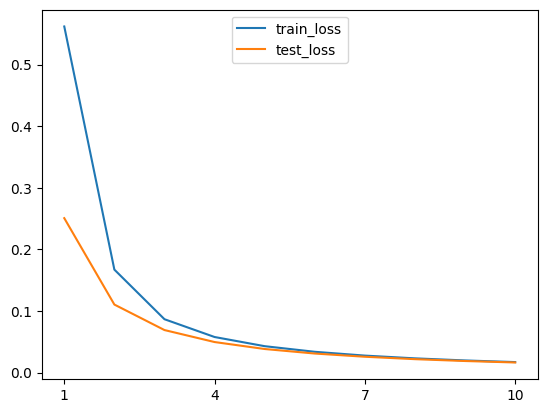

In [56]:
# Define model and parameters
model = NCF(num_users, num_jobs, embedding_dim=5, hidden_dim=32, pretrained_user_embs = None, pretrained_item_embs = None)
lr = 0.001
num_epochs = 10

# Train the model
train_loss, test_loss, user_latent, item_latent = train_NCF(model, train_dataloader, test_dataloader, lr, num_epochs)

## NCF + MF with the pretrained embeddings

Epoch 1 of 10: RMSE Train Loss: 0.3920, RMSE Test Loss: 0.0696
Epoch 2 of 10: RMSE Train Loss: 0.0478, RMSE Test Loss: 0.0331
Epoch 3 of 10: RMSE Train Loss: 0.0267, RMSE Test Loss: 0.0218
Epoch 4 of 10: RMSE Train Loss: 0.0186, RMSE Test Loss: 0.0162
Epoch 5 of 10: RMSE Train Loss: 0.0142, RMSE Test Loss: 0.0128
Epoch 6 of 10: RMSE Train Loss: 0.0114, RMSE Test Loss: 0.0105
Epoch 7 of 10: RMSE Train Loss: 0.0095, RMSE Test Loss: 0.0089
Epoch 8 of 10: RMSE Train Loss: 0.0081, RMSE Test Loss: 0.0076
Epoch 9 of 10: RMSE Train Loss: 0.0070, RMSE Test Loss: 0.0066
Epoch 10 of 10: RMSE Train Loss: 0.0061, RMSE Test Loss: 0.0058


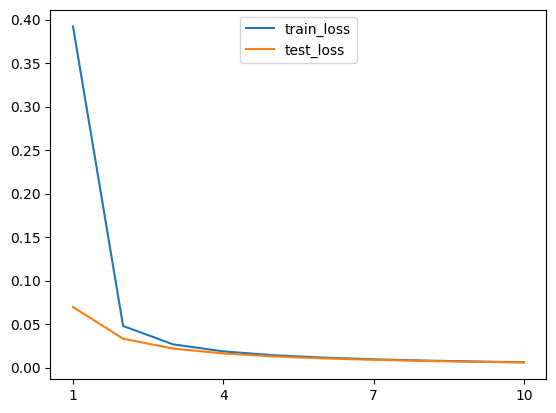

In [57]:
# Define model and parameters
model_with_laten_factors = NCF(num_users, num_jobs, embedding_dim=5, hidden_dim=64, pretrained_user_embs = P1, pretrained_item_embs = Q1.T)
lr = 0.001
num_epochs = 10

# Train the model
train_loss_with_laten_factors, test_loss_with_laten_factors, user_latent_with_laten_factors, item_latent_with_laten_factors = train_NCF(model_with_laten_factors, train_dataloader, test_dataloader, lr, num_epochs)